<span class='note'><i>Make me look good.</i> Click on the cell below and press <kbd>Ctrl</kbd>+<kbd>Enter</kbd>.</span>

In [1]:
from IPython.core.display import HTML
HTML(open('css/custom.css', 'r').read())

<h5 class='prehead'>SM286D &middot; Introduction to Applied Mathematics with Python &middot; Spring 2020 &middot; Uhan</h5>

<h5 class='lesson'>Lesson 18.</h5>

<h1 class='lesson_title'>More genetic algorithms, visualizing location data</h1>

## This lesson...

- Developing a genetic algorithm to solve the __traveling salesperson problem (TSP)__

- Visualizing location data with [**Cartopy**](https://scitools.org.uk/cartopy/docs/latest/)

---

In this lesson, we continue working with genetic algorithms. In the last lesson, we used a genetic algorithm to find a solution to the shortest path problem.  Today, we will develop a different genetic algorithm to find a solution to the __traveling salesperson problem (TSP)__.

The TSP is an important problem in operations research that is easy to state, but often difficult to solve in practice. The TSP asks the following question:

> Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?

Finding efficient solutions to large scale instances of the TSP is important because the TSP has many different applications in planning, logistics, and manufacturing.  In slightly modified forms, the TSP can also appear as a subproblem in many different areas including biology (DNA sequencing) and astronomy (moving telescopes).

The problems below will guide you through the development of a genetic algorithm to solve the TSP.

---

## Classwork

**Problem 1.**
We will develop a genetic algorithm to approximately solve the TSP that visits each of the 61 US national parks. 

<img src="img/grandcanyon.jpg" width=350 />
<br>
<center>
    Figure 1. Wait, <em>what?</em> <a href="https://www.boredpanda.com/one-star-reviews-into-illustrations-national-parks-amber-share">[source]</a>
</center>

The names and locations of all the parks are stored in the Excel workbook `parks.xlsx`, in the same folder as this notebook. For each park, we have its name, its state (or states if the park spans several states), and its latitude and longitude. 

Use `xlwings` to load this data into the lists `parks`, `states`, `lats` and `longs`. 
Print a list of the parks to the screen. 

In [2]:
import xlwings as xw

# Open Book object pointing to workbook
wb = xw.Book('parks.xlsx')

# Open Sheet object pointing to relevant sheet
sht = wb.sheets('Parks')

# Grab the data from the right columns
parks = sht.range('A2').expand('down').value
states = sht.range('B2').expand('down').value
lats = sht.range('C2').expand('down').value 
longs = sht.range('D2').expand('down').value

# Print a list of the parks
# Here, we use the join() method of a string.
# See how it works?
park_name_string = ', '.join(parks)
print(f'The parks are: {park_name_string}.')

The parks are: Zion, Yosemite, Yellowstone, Wrangell–St. Elias, Wind Cave, Voyageurs, Virgin Islands, Theodore Roosevelt, Shenandoah, Sequoia, Saguaro, Rocky Mountain, Redwood, Pinnacles, Petrified Forest, Olympic, North Cascades, Mount Rainier, Mesa Verde, Mammoth Cave, Lassen Volcanic, Lake Clark, Kobuk Valley, Kings Canyon, Kenai Fjords, Katmai, Joshua Tree, Isle Royale, Indiana Dunes, Hot Springs, Hawaiʻi Volcanoes, Haleakalā, Guadalupe Mountains, Great Smoky Mountains, Great Sand Dunes, Great Basin, Grand Teton, Grand Canyon, Glacier, Glacier Bay, Gateway Arch, Gates of the Arctic, Everglades, Dry Tortugas, Denali, Death Valley, Cuyahoga Valley, Crater Lake, Congaree, Channel Islands, Carlsbad Caverns, Capitol Reef, Canyonlands, Bryce Canyon, Black Canyon of the Gunnison, Biscayne, Big Bend, Badlands, Arches, American Samoa, Acadia.


**Problem 2.**

We'd like to plot the locations of the parks on a map of the United States. We'll use the [**Cartopy**](https://scitools.org.uk/cartopy/docs/latest/) package to do this. 

First, we need to install Cartopy. Launch the Anaconda Prompt from the Windows Start Menu (bottom left corner of your screen). Then at the prompt, type 

```
conda install -c conda-forge cartopy
```

This only needs to be done the first time you want to use it. 

The code below produces a map of the United States with major waterways and borders. 

- Use the `ax.plot` method to add the parks to the plot. Recall (e.g., from Lesson 2) that `ax.plot` takes as input a list of $x$ coordinates and a list of $y$ coordinates. In this context, that translates to a list of longitudes and a list of latitudes (in that order).
- Use `ax.plot` options to mark the park locations with red dots.

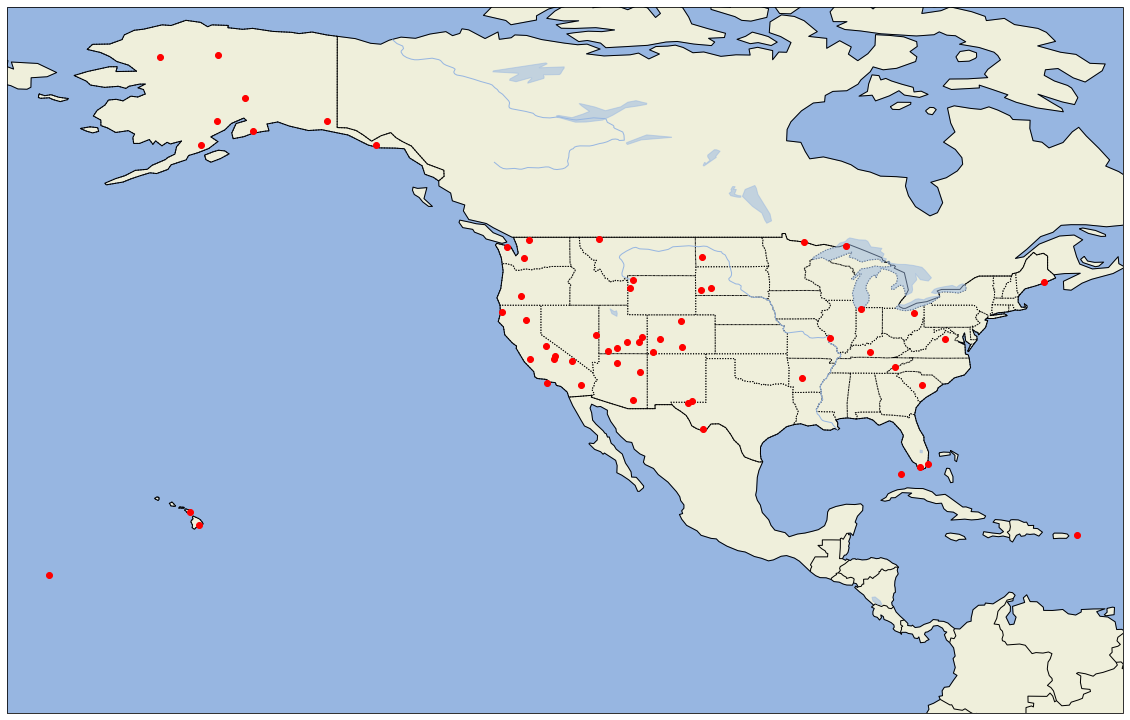

In [3]:
import cartopy 
import matplotlib.pyplot as plt

# Set up a Matplotlib figure and axes
# Put the map of the United States on these axes
# along with geographical features
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.STATES, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-175, -60, 0, 60])

##################################################
# Write your code here to plot the park locations
##################################################
ax.plot(longs, lats, 'ro')

# Show the plot
plt.show()

**Problem 3.**
We need to measure the distance between parks. Finding the distance between two points on Earth given by latitudes and longitudes is complicated. First, we need to convert each latitude and longitude from degrees to radians. Then, under the assumption that the Earth is a sphere of radius $R = 6371000$ meters, the distance between points $(long_1,lat_1)$ and $(long_2,lat_2)$ is given by

\begin{equation*}
R \arccos(\sin(lat_1)\sin(lat_2)+\cos(lat_1)\cos(lat_2)\cos(long_2-long_1)).
\end{equation*}

This distance is given in meters. We can convert it into miles by multiplying by the conversion factor `0.621371/1000`. 

Write a function `airdist` that takes as input two points given by latitude-longitude pairs (`lat1`, `long1`, `lat2`, `long2`), and returns the distance between the two points in miles.

_Hints._ 

- $d$ degrees is equal to $\frac{\pi d}{180}$ radians.
- Import `numpy` as `np` so you can use `np.sin` and other trigonometric functions, as well as `np.pi` for the value of $\pi$.
- Check your work. You should find the distance betwen Zion and Acadia National Parks to be about 2364 miles.

In [4]:
import numpy as np

def airdist(lat1, long1, lat2, long2):
    """
    Compute the distance (as the crow flies) between two points
    whose latitudes and longitudes are given. 
    """
    # Write your code here
    # Convert to radians
    lat1_rad = lat1 * np.pi / 180
    lat2_rad = lat2 * np.pi / 180
    long1_rad = long1 * np.pi / 180
    long2_rad = long2 * np.pi / 180
    
    # Radius of Earth in meters
    R = 6371000
    
    # Distance in meters
    meters = R * np.arccos(
        np.sin(lat1_rad) * np.sin(lat2_rad) + 
        np.cos(lat1_rad) * np.cos(lat2_rad) * np.cos(long2_rad - long1_rad)
    )
    miles = meters * 0.621371 / 1000
    
    return miles

In [5]:
# Check your work
print(f"The distance between Zion and Acadia National Parks is {airdist(37.3, -113.05, 44.35, -68.21)}.")

The distance between Zion and Acadia National Parks is 2363.876952385618.


**Problem 4.**
Set `numparks` equal to the number of parks, 61. Don't do this manually, use `len`.

Use the `airdist` function to compute a $61 \times 61$ matrix named `distances` whose $(i,j)$ entry is the distance in miles between park number $i$ and park number $j$.
Write your code so that all diagonal entries of this matrix are exactly 0: sometimes Python's `arccos` function is inexact.

Check your work: print a sentence showing that the distance between parks 22 and 37 is about 2837.051.

In [6]:
# Number of parks
numparks = len(parks)

# Distance matrix
distances = np.zeros((numparks, numparks))
for i in range(numparks):
    for j in range(numparks):
        if i != j:
            distances[i, j] = airdist(lats[i], longs[i], lats[j], longs[j])

# Check your work
print(f'The distance between parks 22 and 37 is {distances[22, 37]}.')

The distance between parks 22 and 37 is 2837.051309749514.


**Problem 5.**
Since we want to visit each of the parks and return to our starting point, we can store the route that we follow as a __permutation__ of the numbers 0 to 60. We will represent permutations as lists.

For example, the permutation $[0, 24, 32, \dots, 1, 7, 5]$ would correspond to the route that starts at park 0, then goes to park 24, then park 32, and so on, until it reaches park 5. Then the route would go from park 5 back to park 0. This last step isn't included in our permutation, but it is always necessary to include the edge from the last park to the initial park in our route.

Write a function `circuitlength` that 
- takes as input a permutation of the numbers 0 through $n-1$ and an $n \times n$ distance matrix $d$, and 
- returns the length of the circuit corresponding to the permutation (that is, the route that we trace in moving along the route given by the permutation, including the final edge that returns us to the starting place).

Check your work: print a sentence confirming that the `circuitlength` of the permutation 

\begin{equation*}
[0,1,2,3,...,30,60,59,58,...,31]
\end{equation*}

is about 98268.31.

In [7]:
def circuitlength(perm, distances):
    """
    Compute the length of a circuit given as a permutation
    """
    # Number of parks
    n = len(perm)
    
    # Initialize circuit length to 0
    length = 0
    
    # Iterate through the permutation, adding the distances
    for i in range(n - 1):
        length += distances[perm[i], perm[i + 1]]
        
    # Add the edge returning to where we started
    length += distances[perm[n - 1], perm[0]]
    
    return length

# Check your work
p = list(range(0, 31, 1)) + list(range(60, 30, -1))
print(f"The circuit length of the given permutation is {circuitlength(p, distances)}.")

The circuit length of the given permutation is 98268.30855159182.


**Problem 6.**
We will use `circuitlength` from Problem 5 as the fitness function for our genetic algorithm. 

A parent consists of (1) a permutation $p$ of $[0,1,\ldots,60]$ and (2) a score, which is equal to the length $\ell$ of the corresponding circuit.
We start our genetic algorithm by generating 5 random parents. 

We want to choose the permutations randomly. However, it is also nice to be able to reproduce our results. So we set a __seed__ in the random number generator in Python, allowing us to run your code again and again, each time producing the same random output. (You'll learn more about random number generation and seeds in SA421 &mdash; Simulation Modeling.)

 - Read through the code below.
 - Print the last parent.

In [8]:
# Number of parents
numparents = 5

# Set a seed for the random number generator
# Using the same seed results in the same random numbers generated
np.random.seed(210000)

# Create a list of parents
# Each parent is a dictionary consisting of 
# a permutation, and the length of the corresponding circuit
parents = []
for i in range(numparents):
    # Make a random permutation of the list containing 0, 1, ..., 60
    perm = np.random.permutation(list(range(numparks)))
    
    # Add the random permutation and corresponding circuit length
    parents.append({'perm': perm, 'score': circuitlength(perm, distances)})
    
# Write your code below
# Print the last parent
print(f"The last parent is {parents[-1]}.")

The last parent is {'perm': array([37, 55, 26, 33, 58, 24, 15, 30, 41, 13, 12,  7, 43, 29, 44, 23, 34,
       50,  5, 31,  1, 22, 59, 18, 17,  4,  3, 14, 52, 10, 60, 46, 19, 16,
       38, 45,  0, 47,  2, 40,  6, 32,  8, 28, 53, 54, 57, 20, 56, 39, 48,
        9, 49, 42, 35, 25, 36, 21, 51, 27, 11]), 'score': 99652.26621417886}.


**Problem 7.**
The code below defines a function `invert_selection` that takes as input a permutation `perm`, an element `c` and a second element `cp`. The function returns a new permutation, which is obtained from `perm` by reversing the permutation from just after element `c` to just after element `cp`. For example, if 

<pre>
perm = [7, 2, 3, <span style="color:blue">9, 4, 1, 5,</span> 8, 6]
</pre>

and `c = 3` and `cp = 5`, then `invert_selection` returns

<pre>
newperm = [7, 2, 3, <span style="color:blue">5, 1, 4, 9,</span> 8, 6].
</pre>

In fact, a slightly different permutation is returned that gives an equivalent circuit to `newperm`: it follows the same tour but starts at a different element; this is irrelevant for our purposes. 

A second example shows that this isn't as simple as it might seem: if 

<pre>
perm = [<span style="color:blue">7, </span>2, 3, <span style="color:blue">9, 4, 1, 5, 8, 6</span>]
</pre>

and `c = 3` as before but `cp = 7` then we need to wrap around to get the output 

<pre>
newperm = [<span style="color:blue">9</span>, 2, 3, <span style="color:blue">7, 6, 8, 5, 1, 4</span>].
</pre>

Read through the definition of `invert_selection` below. Then test the code with the examples above and ensure that it works as advertised.

In [9]:
def invert_selection(perm, c, cp):
    """
    Invert permutation perm between elements c and cp.
    """
    # We effectively rotate the permutation so that it starts 
    # just after c and ends at c.
    # This is helpful since it means that the portion of the 
    # permutation that we are reversing is at the start.

    # Length of permutation
    n = len(perm)
    
    # Double the permutation
    double_perm = list(perm) + list(perm)
    
    # Find the first index corresponding to c
    c_index = double_perm.index(c)
    
    # Rotate the permutation to start just after and end at c
    rotated_perm = double_perm[c_index + 1:c_index + n + 1]
    
    # Reverse the initial part of the rotated permutation,
    # between elements c and cp
    cp_index = rotated_perm.index(cp)
    
    newperm = rotated_perm[cp_index::-1] + rotated_perm[cp_index + 1::1]
    return newperm

In [10]:
# Test the code in this code cell
print(invert_selection([7, 2, 3, 9, 4, 1, 5, 8, 6], 3, 5))
print(invert_selection([7, 2, 3, 9, 4, 1, 5, 8, 6], 3, 7))

[5, 1, 4, 9, 8, 6, 7, 2, 3]
[7, 6, 8, 5, 1, 4, 9, 2, 3]


**Problem 8.**
Implement a genetic algorithm for the TSP, using the following steps.

- Initialize the number of generations `num_gens` to 4000.
- In each generation, each parent produces one child. The child is a copy of the parent but two locations are exchanged:
    - Select a random index `a` from 0 to 59 (inclusive) &mdash; use `np.random.randint` to do this.
    - Next, select a random index `b` from `a + 1` to 60. 
    - Now create the child by swapping the values of the parent's permutation at index `a` and index `b`.
- Perform local improvement on each child:
    - Generate a random number between 0 and 1 &mdash; use `np.random.random` to do this.
    - If this number is less than 0.01, stop local improvement for this child.
    - If this number is at least 0.01, we randomly select another two indices `a` and `b` (with `a < b`), and invert the portion of the child's permutation starting just after the element with index `a` and continuing until just after the element with index `b`. 
        - Use the `invert_selection` function to do this. Note that the definition of that function calls for elements to be input into the function, not indices.
     - Repeat this process until local improvement is stopped.
- After the local improvement process stops, we compare the child to the parent. If the child's score is better than the parent's, we replace the parent with the child.

In [11]:
# Set number of generations
num_gens = 4000

# Set probability threshhold
prob = 0.01

# Iterate over all generations
for i in range(num_gens):
    
    # Print number of iterations, so we can see progress
    if i % 100 == 0:
        print(f"Iteration {i}")
    
    # Iterate over all parents
    for j in range(numparents):
        
        # Current parent
        parent = parents[j]
        
        # Current parent's permutation
        # We want to copy the list, since this will eventually form the child's permutation
        perm = parent['perm'][:]  
        
        # Current parent's score
        score = parent['score']
        
        # Choose random indices a and b so that a < b
        a = np.random.randint(0, numparks - 1)
        b = np.random.randint(a + 1, numparks)
        
        # Swap elements with indices a and b
        # This part is tricky: if you write perm[a] = perm[b],
        # then you can't write perm[b] = perm[a], since you've already
        # overwritten perm[a]!
        # Use some extra variables to get around this
        element_a = perm[a] 
        element_b = perm[b]
        perm[a] = element_b
        perm[b] = element_a
        
        # Create child
        child = {'perm': perm, 'score': circuitlength(perm, distances)}
        
        # Local improvement for child
        while True: 
            if np.random.random() < prob:
                break
            else:
                # Choose random indices a and b so that a < b
                a = np.random.randint(0, numparks - 1)
                b = np.random.randint(a + 1, numparks)
                
                # Copy the child's permutation, then invert 
                new_perm = perm[:]
                new_perm = invert_selection(new_perm, new_perm[a], new_perm[b])
                
                # Compute fitness of inverted permutation
                new_score  = circuitlength(new_perm, distances)
                
                # If this inversion improves the child, keep the change
                if new_score < child['score']:
                    child = {'perm': new_perm, 'score': new_score}

        # Survival of the fittest - compare child with parent 
        if child['score'] < parent['score']: 
            parents[j] = child

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900


**Problem 9.**
Once your genetic algorithm has completed 4000 generations, print the fittest parent's route (i.e., permutation) as well as the length of the corresponding circuit.

In [12]:
# Initialize minimum score
min_score = float("inf")

# Initialize parent with minimum score
min_parent = None

# Iterate through parents
# Find parent with minimum score
for parent in parents:
    if parent['score'] < min_score:
        min_score = parent['score']
        min_parent = parent

# Create list that contains the entire tour
# Don't forget to include the starting park twice!
min_tour = list(parent['perm']) + [parent['perm'][0]]

print(f'The best route found is {min_parent["score"]:0.2f} miles long.')
print(f'The best route found is: {min_tour}.')

The best route found is 22768.33 miles long.
The best route found is: [51, 35, 45, 26, 49, 9, 23, 1, 13, 30, 31, 59, 25, 24, 21, 22, 41, 44, 3, 39, 15, 16, 17, 47, 12, 20, 36, 2, 38, 7, 5, 27, 28, 46, 8, 60, 6, 55, 42, 43, 48, 33, 19, 29, 40, 57, 4, 11, 34, 54, 58, 52, 18, 50, 32, 56, 10, 14, 37, 0, 53, 51].


**Problem 10.**
Print the *names* of the parks in the order in which you visit them (including one of the parks twice since you visit it first and then return to that park at the end of your journey).

In [13]:
# Create a list of the park names, in the order given by the tour
min_tour_names = [parks[i] for i in min_tour]

# Let's use the join() method of a string again
min_tour_names_string = ', '.join(min_tour_names)
print(f'We should visit the parks in the following order: {min_tour_names_string}.')

We should visit the parks in the following order: Capitol Reef, Great Basin, Death Valley, Joshua Tree, Channel Islands, Sequoia, Kings Canyon, Yosemite, Pinnacles, Hawaiʻi Volcanoes, Haleakalā, American Samoa, Katmai, Kenai Fjords, Lake Clark, Kobuk Valley, Gates of the Arctic, Denali, Wrangell–St. Elias, Glacier Bay, Olympic, North Cascades, Mount Rainier, Crater Lake, Redwood, Lassen Volcanic, Grand Teton, Yellowstone, Glacier, Theodore Roosevelt, Voyageurs, Isle Royale, Indiana Dunes, Cuyahoga Valley, Shenandoah, Acadia, Virgin Islands, Biscayne, Everglades, Dry Tortugas, Congaree, Great Smoky Mountains, Mammoth Cave, Hot Springs, Gateway Arch, Badlands, Wind Cave, Rocky Mountain, Great Sand Dunes, Black Canyon of the Gunnison, Arches, Canyonlands, Mesa Verde, Carlsbad Caverns, Guadalupe Mountains, Big Bend, Saguaro, Petrified Forest, Grand Canyon, Zion, Bryce Canyon, Capitol Reef.


**Problem 11.**
It would be nice to visualize what this tour looks like. Plot the resulting circuit (in black) on top of your figure from Problem 2.

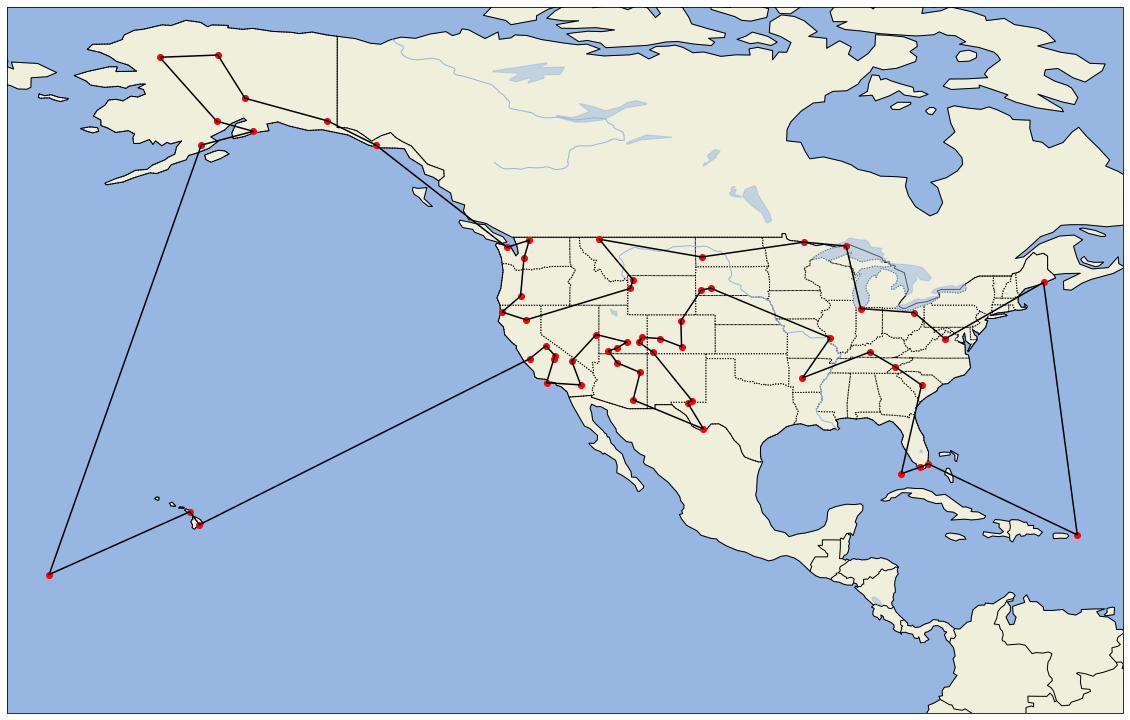

In [14]:
# Create lists of longitude and latitude for the tour
tour_longs = [longs[i] for i in min_tour]
tour_lats = [lats[i] for i in min_tour]

# Set up a Matplotlib figure and axes
# Put the map of the United States on these axes
# along with geographical features
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.STATES, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-175, -60, 0, 60])

# Display park locations as red dots
ax.plot(longs, lats, 'ro')

# Display tour using a black line
ax.plot(tour_longs, tour_lats, 'k-')  # new code! 

plt.show()